# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Initial Exploration

In [2]:
print("PORTFOLIO")
print(portfolio.shape)
portfolio.head(20)

PORTFOLIO
(10, 6)


reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [3]:
channels = set()
for each in portfolio.channels.values:
    # c = each.replace("[","").replace("]","").replace(",","").split()
    c = set(each)
    channels = channels.union(c)

for channel in channels:
    portfolio[channel] = 0
    portfolio.loc[portfolio.channels.apply(lambda x: channel in x), channel] = 1

portfolio["offername"] = portfolio["offer_type"] + "_" + portfolio["duration"].astype(str) + "_" + portfolio["difficulty"].astype(str) + "_" + portfolio["reward"].astype(str)

portfolio.head(20)



reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  social  web  email  mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd       1    0      1       1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0       1    1      1       1   
2  3f207df678b143eea3cee63160fa8bed       0    1      1       1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9       0    1      1       1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       0    1      1       0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       1    1      1       1   
6  fafdcd668e3743c1bb461111dcafc2a4       1    1      1       1   
7  5a8bc65990b245e5a138643cd4eb9837       1    0      1       1   
8  f19421c1d4aa40978ebb69ca19b0e20d       1    1      1       1   
9  2906b810c7d4411798c6938adc9daaa5       0    1      1       1   

             offername  
0         bogo_7_10_10  
1         bogo_5_10_10  
2  informational_4_0_0  
3           bogo_7_5_5  
4     discount_10_20_5  
5       discount_7_7_3  
6     discount_10_10_2  
7  informational_3_0_0  
8           bogo_5_5_5  
9      discount_7_10_2

In [4]:
print("PROFILE")
print(profile.shape)
profile.head(20)

PROFILE
(17000, 5)


gender  age                                id  became_member_on    income
0    None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1       F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2    None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3       F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4    None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN
5       M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
6    None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925       NaN
7    None  118  68617ca6246f4fbc85e91a2a49552598          20171002       NaN
8       M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
9    None  118  8974fc5686fe429db53ddde067b88302          20161122       NaN
10   None  118  c4863c7985cf408faee930f111475da3          20170824       NaN
11   None  118  148adfcaa27d485b82f323aaaad036bd          20150919       NaN
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0
13      F   61  aa4862eba776480b8bb9c68455b8c2e1          20170911   57000.0
14      M   26  e12aeaf2d47d42479ea1c4ac3d8286c6          20140213   46000.0
15      F   62  31dda685af34476cad5bc968bdb01c53          20160211   71000.0
16      M   49  62cf5e10845442329191fc246e7bcea3          20141113   52000.0
17   None  118  744d603ef08c4f33af5a61c8c7628d1c          20170801       NaN
18      M   57  6445de3b47274c759400cd68131d91b4          20171231   42000.0
19      F   61  a448667f336b42c9a66fc5ffd5d73772          20180501   40000.0

In [5]:
profile["joindate"] = pd.to_datetime(profile["became_member_on"],format="%Y%m%d")
profile["tenure"] = (profile["joindate"] - profile["joindate"].min()).dt.days
profile.tenure.describe()


count    17000.000000
mean      1305.550118
std        411.223904
min          0.000000
25%       1032.000000
50%       1465.000000
75%       1615.000000
max       1823.000000
Name: tenure, dtype: float64

In [6]:
profile.head()

gender  age                                id  became_member_on    income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN   
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN   

    joindate  tenure  
0 2017-02-12    1294  
1 2017-07-15    1447  
2 2018-07-12    1809  
3 2017-05-09    1380  
4 2017-08-04    1467

===== GENDER ======
M       8484
F       6129
None    2175
O        212
Name: gender, dtype: int64
===== AGE ======
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64


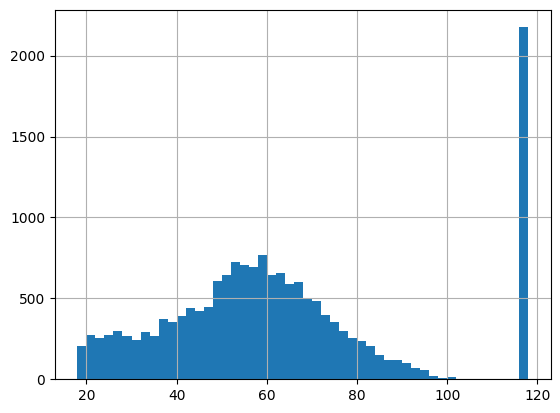

===== INCOME ======
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


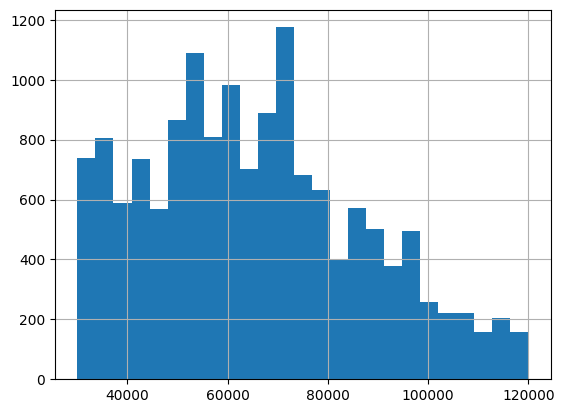

In [7]:
print("===== GENDER ======")
print(profile["gender"].value_counts(dropna=False))
print("===== AGE ======")
print(profile.age.describe())
plt.show(profile.age.hist(bins=50));
print("===== INCOME ======")
print(profile.income.describe())
plt.show(profile.income.hist(bins=25));


In [8]:
print("TRANSCRIPT")
print(transcript.shape)
transcript.head(20)

TRANSCRIPT
(306534, 4)


person           event  \
0   78afa995795e4d85b5d9ceeca43f5fef  offer received   
1   a03223e636434f42ac4c3df47e8bac43  offer received   
2   e2127556f4f64592b11af22de27a7932  offer received   
3   8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4   68617ca6246f4fbc85e91a2a49552598  offer received   
5   389bc3fa690240e798340f5a15918d5c  offer received   
6   c4863c7985cf408faee930f111475da3  offer received   
7   2eeac8d8feae4a8cad5a6af0499a211d  offer received   
8   aa4862eba776480b8bb9c68455b8c2e1  offer received   
9   31dda685af34476cad5bc968bdb01c53  offer received   
10  744d603ef08c4f33af5a61c8c7628d1c  offer received   
11  3d02345581554e81b7b289ab5e288078  offer received   
12  4b0da7e80e5945209a1fdddfe813dbe0  offer received   
13  c27e0d6ab72c455a8bb66d980963de60  offer received   
14  d53717f5400c4e84affdaeda9dd926b3  offer received   
15  f806632c011441378d4646567f357a21  offer received   
16  d058f73bf8674a26a95227db098147b1  offer received   
17  65aba5c617294649aeb624da249e1ee5  offer received   
18  ebe7ef46ea6f4963a7dd49f501b26779  offer received   
19  1e9420836d554513ab90eba98552d0a9  offer received   

                                               value  time  
0   {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1   {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2   {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4   {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
5   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
6   {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}     0  
7   {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
8   {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
9   {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
10  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
11  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
12  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}     0  
13  {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
14  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
15  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
16  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
17  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
18  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
19  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}     0

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


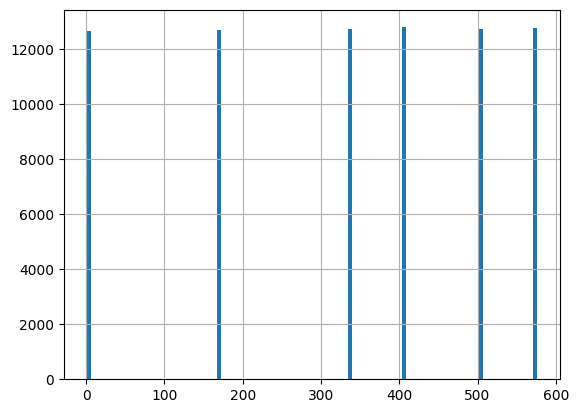

In [9]:
print(transcript.event.value_counts(dropna=False))

plt.show(transcript[transcript["event"] == "offer received"].time.hist(bins=100))

In [10]:
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [11]:
714/24

29.75

In [12]:
transcript[transcript.event=="offer completed"].tail()

person            event  \
306475  0c027f5f34dd4b9eba0a25785c611273  offer completed   
306497  a6f84f4e976f44508c358cc9aba6d2b3  offer completed   
306506  b895c57e8cd047a8872ce02aa54759d6  offer completed   
306509  8431c16f8e1d440880db371a68f82dd0  offer completed   
306527  24f56b5e1849462093931b164eb803b5  offer completed   

                                                    value  time  
306475  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...   714  
306497  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...   714  
306506  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  
306509  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  
306527  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714

In [13]:
transcript[transcript.person == "24f56b5e1849462093931b164eb803b5"]

person            event  \
49497   24f56b5e1849462093931b164eb803b5      transaction   
51345   24f56b5e1849462093931b164eb803b5      transaction   
98955   24f56b5e1849462093931b164eb803b5      transaction   
123504  24f56b5e1849462093931b164eb803b5   offer received   
163333  24f56b5e1849462093931b164eb803b5   offer received   
177250  24f56b5e1849462093931b164eb803b5     offer viewed   
214243  24f56b5e1849462093931b164eb803b5   offer received   
221893  24f56b5e1849462093931b164eb803b5     offer viewed   
306526  24f56b5e1849462093931b164eb803b5      transaction   
306527  24f56b5e1849462093931b164eb803b5  offer completed   

                                                    value  time  
49497                                   {'amount': 21.39}   138  
51345                                   {'amount': 14.12}   150  
98955                                   {'amount': 16.92}   264  
123504   {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}   336  
163333   {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   408  
177250   {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   426  
214243   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   504  
221893   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   510  
306526                                  {'amount': 22.64}   714  
306527  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714

### I want to make this transcript table easier to read, so I will de-normalize it

In [14]:
df = transcript.merge(profile,how='left',left_on='person',right_on='id')
df = df[[
    "person",
    "event",
    "value",
    "time",
    "gender",
    "age",
    "income",
    "tenure"
]]

df["amount"] = df.value.apply(lambda x: x.get("amount",0))
df["offerid"] = df.value.apply(lambda x: x.get("offer id",x.get("offer_id",0)))

df = df.merge(portfolio, how='left', left_on="offerid", right_on="id")

df = df[[
    "person",
    "event",
    # "value",
    "time",
    "gender",
    "age",
    "income",
    "tenure",
    "amount",
    'offername',
    'channels', 
    'reward', 
    'difficulty', 
    'duration', 
    'offer_type', 
       'mobile', 'web', 'social', 'email', 
]]

df.time = df.time/24.0

df.head()

person           event  time gender  age  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   0.0      F   75   
1  a03223e636434f42ac4c3df47e8bac43  offer received   0.0   None  118   
2  e2127556f4f64592b11af22de27a7932  offer received   0.0      M   68   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   0.0   None  118   
4  68617ca6246f4fbc85e91a2a49552598  offer received   0.0   None  118   

     income  tenure  amount         offername                      channels  \
0  100000.0    1380     0.0        bogo_7_5_5          [web, email, mobile]   
1       NaN    1467     0.0  discount_10_20_5                  [web, email]   
2   70000.0    1732     0.0   discount_7_10_2          [web, email, mobile]   
3       NaN    1519     0.0  discount_10_10_2  [web, email, mobile, social]   
4       NaN    1526     0.0      bogo_5_10_10  [web, email, mobile, social]   

   reward  difficulty  duration offer_type  mobile  web  social  email  
0     5.0         5.0       7.0       bogo     1.0  1.0     0.0    1.0  
1     5.0        20.0      10.0   discount     0.0  1.0     0.0    1.0  
2     2.0        10.0       7.0   discount     1.0  1.0     0.0    1.0  
3     2.0        10.0      10.0   discount     1.0  1.0     1.0    1.0  
4    10.0        10.0       5.0       bogo     1.0  1.0     1.0    1.0

In [15]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  social  web  email  mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd       1    0      1       1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0       1    1      1       1   
2  3f207df678b143eea3cee63160fa8bed       0    1      1       1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9       0    1      1       1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       0    1      1       0   

             offername  
0         bogo_7_10_10  
1         bogo_5_10_10  
2  informational_4_0_0  
3           bogo_7_5_5  
4     discount_10_20_5

In [16]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id',
       'social', 'web', 'email', 'mobile', 'offername'],
      dtype='object')

In [17]:
df[df.person=="ffff82501cea40309d5fdd7edcca4a07"]

person            event   time gender  age  \
1393    ffff82501cea40309d5fdd7edcca4a07   offer received   0.00      F   45   
15836   ffff82501cea40309d5fdd7edcca4a07     offer viewed   0.25      F   45   
32762   ffff82501cea40309d5fdd7edcca4a07      transaction   2.50      F   45   
32763   ffff82501cea40309d5fdd7edcca4a07  offer completed   2.50      F   45   
37060   ffff82501cea40309d5fdd7edcca4a07      transaction   3.25      F   45   
45575   ffff82501cea40309d5fdd7edcca4a07      transaction   5.00      F   45   
54574   ffff82501cea40309d5fdd7edcca4a07   offer received   7.00      F   45   
69626   ffff82501cea40309d5fdd7edcca4a07     offer viewed   7.25      F   45   
79667   ffff82501cea40309d5fdd7edcca4a07      transaction   8.25      F   45   
79668   ffff82501cea40309d5fdd7edcca4a07  offer completed   8.25      F   45   
81594   ffff82501cea40309d5fdd7edcca4a07      transaction   8.50      F   45   
90697   ffff82501cea40309d5fdd7edcca4a07      transaction   9.75      F   45   
97830   ffff82501cea40309d5fdd7edcca4a07      transaction  11.00      F   45   
107052  ffff82501cea40309d5fdd7edcca4a07      transaction  13.00      F   45   
112214  ffff82501cea40309d5fdd7edcca4a07   offer received  14.00      F   45   
133074  ffff82501cea40309d5fdd7edcca4a07     offer viewed  14.75      F   45   
143787  ffff82501cea40309d5fdd7edcca4a07      transaction  16.00      F   45   
143788  ffff82501cea40309d5fdd7edcca4a07  offer completed  16.00      F   45   
152030  ffff82501cea40309d5fdd7edcca4a07   offer received  17.00      F   45   
168022  ffff82501cea40309d5fdd7edcca4a07     offer viewed  17.25      F   45   
168023  ffff82501cea40309d5fdd7edcca4a07      transaction  17.25      F   45   
168024  ffff82501cea40309d5fdd7edcca4a07  offer completed  17.25      F   45   
200255  ffff82501cea40309d5fdd7edcca4a07      transaction  20.75      F   45   
202962  ffff82501cea40309d5fdd7edcca4a07   offer received  21.00      F   45   
214716  ffff82501cea40309d5fdd7edcca4a07      transaction  21.00      F   45   
214717  ffff82501cea40309d5fdd7edcca4a07  offer completed  21.00      F   45   
230690  ffff82501cea40309d5fdd7edcca4a07     offer viewed  22.25      F   45   
246495  ffff82501cea40309d5fdd7edcca4a07   offer received  24.00      F   45   
258361  ffff82501cea40309d5fdd7edcca4a07      transaction  24.00      F   45   
258362  ffff82501cea40309d5fdd7edcca4a07  offer completed  24.00      F   45   
262475  ffff82501cea40309d5fdd7edcca4a07     offer viewed  24.25      F   45   
274809  ffff82501cea40309d5fdd7edcca4a07      transaction  25.25      F   45   
289924  ffff82501cea40309d5fdd7edcca4a07      transaction  27.00      F   45   

         income  tenure  amount         offername  \
1393    62000.0    1215    0.00  discount_10_10_2   
15836   62000.0    1215    0.00  discount_10_10_2   
32762   62000.0    1215   16.06               NaN   
32763   62000.0    1215    0.00  discount_10_10_2   
37060   62000.0    1215    7.18               NaN   
45575   62000.0    1215    9.12               NaN   
54574   62000.0    1215    0.00  discount_10_20_5   
69626   62000.0    1215    0.00  discount_10_20_5   
79667   62000.0    1215   22.88               NaN   
79668   62000.0    1215    0.00  discount_10_20_5   
81594   62000.0    1215   15.23               NaN   
90697   62000.0    1215   18.08               NaN   
97830   62000.0    1215   23.32               NaN   
107052  62000.0    1215   16.86               NaN   
112214  62000.0    1215    0.00   discount_7_10_2   
133074  62000.0    1215    0.00   discount_7_10_2   
143787  62000.0    1215   15.57               NaN   
143788  62000.0    1215    0.00   discount_7_10_2   
152030  62000.0    1215    0.00   discount_7_10_2   
168022  62000.0    1215    0.00   discount_7_10_2   
168023  62000.0    1215   17.55               NaN   
168024  62000.0    1215    0.00   discount_7_10_2   
200255  62000.0    1215   13.17               NaN   
202962  62000.0    1215    0.00        bo

In [18]:
df[df.event == "offer received"].tail(20)

person           event  time gender  age  \
257867  eb7dd979f4644052a5c401a01f129132  offer received  24.0   None  118   
257868  54bead4179c44b71acc4e8398181d183  offer received  24.0      F   29   
257869  a00058cf10334a308c68e7631c529907  offer received  24.0      F   63   
257870  5c686d09ca4d475a8f750f2ba07e0440  offer received  24.0   None  118   
257871  1966fa40d2f84620b2b1b9b64f8e0209  offer received  24.0      M   84   
257872  ff737c250d2343729ade04c4f6eb1001  offer received  24.0      F   72   
257873  392d23b2c958493197f647bedfe4f418  offer received  24.0      F   75   
257874  97ee6e7a12fe4064b260fa48bdd0330f  offer received  24.0      M   26   
257875  bf3069b178fe40d789dd027901bc406b  offer received  24.0      F   59   
257876  76ddbd6576844afe811f1a3c0fbb5bec  offer received  24.0      M   57   
257877  f653cf2d8bba42d0a53c2937ee2e5893  offer received  24.0      M   64   
257878  ca45ee1883624304bac1e4c8a114f045  offer received  24.0   None  118   
257879  670626b55bfb4ba39c85b27cc7cca527  offer received  24.0      M   21   
257880  f924927e7f844ecebf87eef93f4d2688  offer received  24.0      M   47   
257881  a57890c3bbb7463e9018abb7fecadb15  offer received  24.0      M   57   
257882  d087c473b4d247ccb0abfef59ba12b0e  offer received  24.0      M   56   
257883  cb23b66c56f64b109d673d5e56574529  offer received  24.0      M   60   
257884  6d5f3a774f3d4714ab0c092238f3a1d7  offer received  24.0      F   45   
257885  9dc1421481194dcd9400aec7c9ae6366  offer received  24.0      F   83   
257886  e4052622e5ba45a8b96b59aba68cf068  offer received  24.0      F   62   

          income  tenure  amount            offername  \
257867       NaN    1046     0.0           bogo_5_5_5   
257868   58000.0    1302     0.0      discount_7_10_2   
257869   52000.0      55     0.0           bogo_7_5_5   
257870       NaN    1130     0.0      discount_7_10_2   
257871   93000.0    1066     0.0           bogo_5_5_5   
257872   65000.0     614     0.0     discount_10_20_5   
257873   78000.0    1083     0.0         bogo_7_10_10   
257874   55000.0    1786     0.0           bogo_7_5_5   
257875   63000.0    1463     0.0     discount_10_20_5   
257876   40000.0    1076     0.0           bogo_7_5_5   
257877   51000.0    1620     0.0           bogo_7_5_5   
257878       NaN    1680     0.0  informational_4_0_0   
257879   39000.0    1017     0.0     discount_10_20_5   
257880   93000.0    1035     0.0  informational_3_0_0   
257881   77000.0    1626     0.0  informational_3_0_0   
257882   51000.0    1182     0.0         bogo_7_10_10   
257883  113000.0    1741     0.0      discount_7_10_2   
257884   54000.0    1771     0.0       discount_7_7_3   
257885   50000.0     952     0.0         bogo_7_10_10   
257886   82000.0    1454     0.0  informational_4_0_0   

                            channels  reward  difficulty  duration  \
257867  [web, email, mobile, social]     5.0         5.0       5.0   
257868          [web, email, mobile]     2.0        10.0       7.0   
257869          [web, email, mobile]     5.0         5.0       7.0   
257870          [web, email, mobile]     2.0        10.0       7.0   
257871  [web, email, mobile, social]     5.0         5.0       5.0   
257872                  [web, email]     5.0        20.0      10.0   
257873       [email, mobile, social]    10.0        10.0       7.0   
257874          [web, email, mobile]     5.0         5.0       7.0   
257875                  [web, email]     5.0        20.0      10.0   
257876          [web, email, mobile]     5.0         5.0       7.0   
257877          [web, email, mobile]     5.0         5.0       7.0   
257878          [web, email, mobile]     0.0         0.0       4.0   
257879                  [web, email]     5.0        20.0      10.0   
257880       [email, mobile, social]     0.0         0.0       3.0   
257881       [email, mobile, social]     0.0         0.0       3.0   
257882       [email, mobile, social]    10.0        10.0       7.0   
257883 

# Define the problems we want to solve

1. We want to optimize the return on our offers:
    - send the RIGHT offers to the RIGHT groups
    - we know if offers are COMPLETED, but not REDEEMED. I am going to make the SIGNIFICANT assumption that we wish to maximize engagement (spending), meaning there is NO upper limit on the amount of offers we can send.
    - we can control the "offer received" lever, so this is our most important variable. Ultimately, do customers who get sent offers spend more?
2. My goal - deliver a plan for who should receive offers.
    - how frequent should offers go out? do the offers change? If someone turns out to be responding well, should we chage the plan vs if they do not respond well?
        - this is a pretty short time frame to look at, so I don't know if we can really make good judgements based on that.
    - **For the given variables (income, age, gender, tenure) what is the best set of offers that maximizes spending?**
    - explore maximizing per-customer spending vs maximizing overall income. Is it better to cultivate "whales" if the return is better?

In [222]:
person_g = df.groupby([
    "person",
    "gender",
    "age",
    "income",
    "tenure"
])

person_spend = person_g.amount.sum()
person_mobile = person_g.mobile.sum()
person_web = person_g.web.sum()
person_social = person_g.social.sum()
person_email = person_g.email.sum()

person_g_offersonly = df[df.event == "offer received"].groupby([
    "person",
    "gender",
    "age",
    "income",
    "tenure"
])

person_offers_total = person_g_offersonly.offername.count()

person_offers = df[df.event == "offer received"].pivot_table(index=[
    "person",
    "gender",
    "age",
    "income",
    "tenure"
], columns='offername', aggfunc='size', fill_value=0)

person_offers_type = df[df.event == "offer received"].pivot_table(index=[
    "person",
    "gender",
    "age",
    "income",
    "tenure"
], columns='offer_type', aggfunc='size', fill_value=0)

person_events = df.pivot_table(index=[
    "person",
    "gender",
    "age",
    "income",
    "tenure"
], columns='event', aggfunc='size', fill_value=0)

for col in person_events:
    person_offers[col] = person_events[col]

for col in person_offers_type:
    person_offers[col] = person_offers_type[col]

person_offers["spend"] = person_spend
person_offers["totaloffers"] = person_offers_total
person_offers["spendpertransaction"] = person_offers["spend"] / person_offers["transaction"]

person_offers["mobile"] = person_mobile
person_offers["web"] = person_web
person_offers["social"] = person_social
person_offers["email"] = person_email

# person_offers

df_p = person_offers.reset_index()
df_p

offername                            person gender  age   income  tenure  \
0          0009655768c64bdeb2e877511632db8f      M   33  72000.0    1362   
1          0011e0d4e6b944f998e987f904e8c1e5      O   40  57000.0    1625   
2          0020c2b971eb4e9188eac86d93036a77      F   59  90000.0     949   
3          0020ccbbb6d84e358d3414a3ff76cffd      F   24  60000.0    1201   
4          003d66b6608740288d6cc97a6903f4f0      F   26  73000.0    1423   
...                                     ...    ...  ...      ...     ...   
14815      fff3ba4757bd42088c044ca26d73817a      F   69  83000.0     783   
14816      fff7576017104bcc8677a8d63322b5e1      M   71  73000.0    1555   
14817      fff8957ea8b240a6b5e634b6ee8eafcf      M   71  56000.0    1665   
14818      fffad4f4828548d1b5583907f2e9906b      M   34  34000.0    1274   
14819      ffff82501cea40309d5fdd7edcca4a07      F   45  62000.0    1215   

offername  bogo_5_10_10  bogo_5_5_5  bogo_7_10_10  bogo_7_5_5  \
0                     0           1             0           0   
1                     0           0             0           1   
2                     1           0             1           0   
3                     0           1             0           1   
4                     0           0             0           0   
...                 ...         ...           ...         ...   
14815                 0           0             0           1   
14816                 1           0             1           1   
14817                 1           0             0           0   
14818                 0           2             0           1   
14819                 0           0             0           1   

offername  discount_10_10_2  discount_10_20_5  discount_7_10_2  \
0                         1                 0                1   
1                         0                 1                0   
2                         2                 0                0   
3                         0                 0                0   
4                         2                 1                0   
...                     ...               ...              ...   
14815                     1                 0                2   
14816                     2                 0                0   
14817                     1                 0                0   
14818                     0                 0                0   
14819                     1                 1                3   

offername  discount_7_7_3  informational_3_0_0  informational_4_0_0  \
0                       0                    1                    1   
1                       1                    1                    1   
2                       0                    1                    0   
3                       1                    1                    0   
4                       0                    1                    1   
...                   ...                  ...                  ...   
14815                   0                    2                    0   
14816                   0                    0                    0   
14817                   0                    0                    1   
14818                   0                    1                    0   
14819                   0                    0                    0   

offername  offer completed  offer received  offer viewed  transaction  bogo  \
0                        3               5             4            8     1   
1                        3               5             5            5     1   
2                        3               5             3            8     2   
3                        3               4             4           12     2   
4                        3               5             4           18     0   
...                    ...             ...           ...          ...   ...   
14815                    3               6             3           11     1   
14816                    3  

In [55]:
def box_by_age(df):
    df["age_bin"] = (df.age // 5)*5
    vals, names, xs = [], [], []
    for i, name in enumerate(sorted(df.age_bin.unique())):
        dfa = df[df.age_bin==name]
        vals.append(dfa.spend.values)
        names.append(name)
        xs.append(np.random.normal(i+1, .04,len(dfa)))
    
    plt.figure(figsize=(10,5))
    
    plt.boxplot(vals,labels=names,showfliers=False)
    for x, val in zip(xs, vals):
        plt.scatter(x, val, alpha=0.6, s=.2)

    plt.title('Spending by Age bin (number + 4)')
    plt.xlabel('Age')
    plt.ylabel('Spending')
    plt.ylim([0,400])

    plt.show()


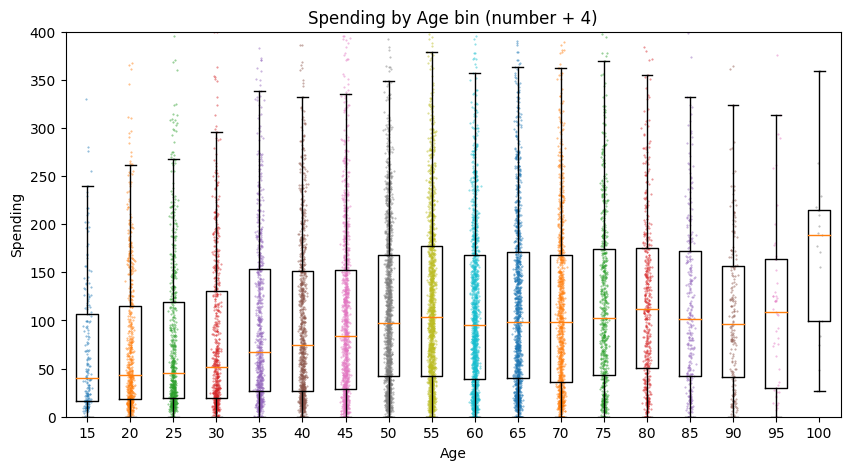

In [56]:
box_by_age(df_p)

In [164]:
# where does most of our income come from?
def profit_by_group(df, grouper = "spend", binsize = 30, ulim=None):
    df["bin"] = (df[grouper] // binsize) * binsize
    dfspending = df.groupby("bin").spend.sum()
    dfcounts = df.groupby("bin").spend.count()

    dfspend = pd.DataFrame()
    dfspend["spend"] = dfspending
    dfspend["counts"] = dfcounts
    
    
    dfspend = dfspend.reset_index().sort_values("bin")
    total_spend = dfspend.spend.sum()
    total_count = dfspend.counts.sum()

    dfspend["fraction_of_profit"] = dfspend.spend / total_spend
    dfspend["fraction_of_users"] = dfspend.counts / total_count


    plt.figure(figsize=(10,5))
    w = binsize*.4
    plt.bar(dfspend.bin, dfspend.fraction_of_profit, width=w, align='edge', label = "profits")
    plt.bar(dfspend.bin-w, dfspend.fraction_of_users, width=w, align='edge', label = "users")

    plt.title(f'Fraction of profits coming from customers grouped by {grouper}')
    plt.xlabel(f'{grouper}')
    plt.ylabel('Fraction of: Profit (blue), Users (orange)')
    plt.legend()
    if ulim:
        plt.xlim([0-w*2,ulim])

    plt.show()


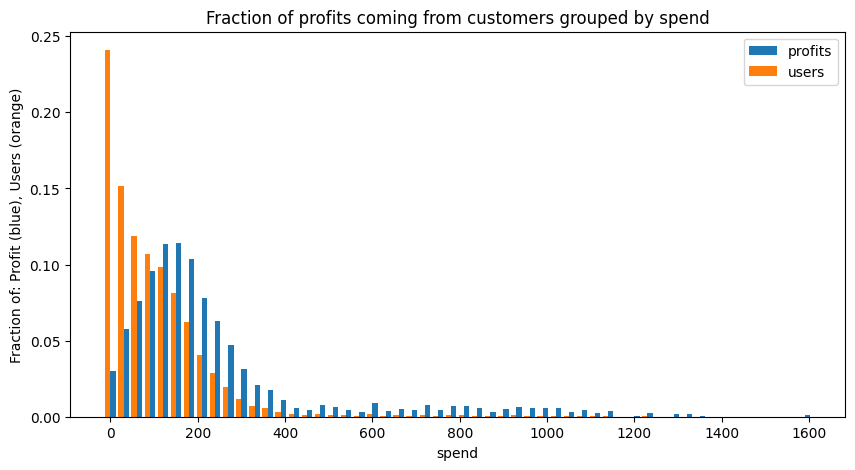

In [162]:
profit_by_group(df_p)

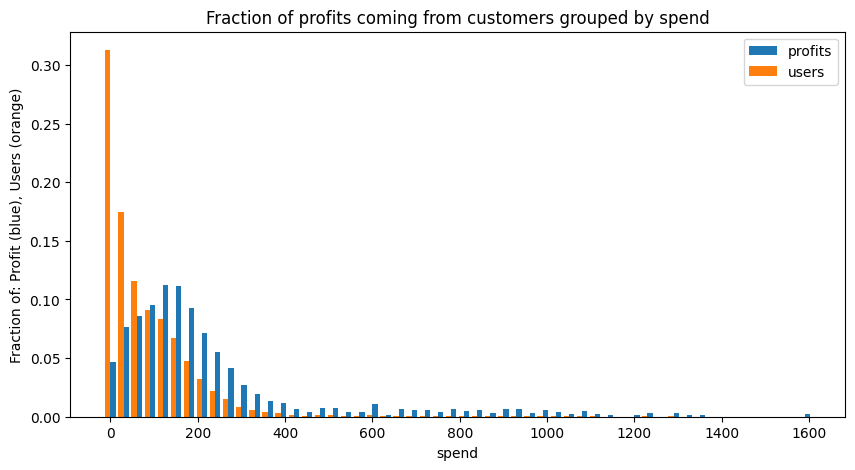

In [140]:
profit_by_group(df_p[df_p.gender=="M"])

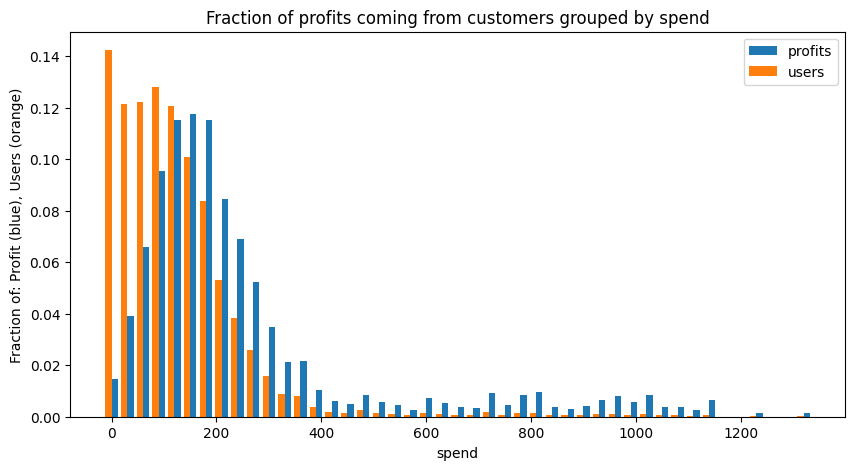

In [141]:
profit_by_group(df_p[df_p.gender=="F"])

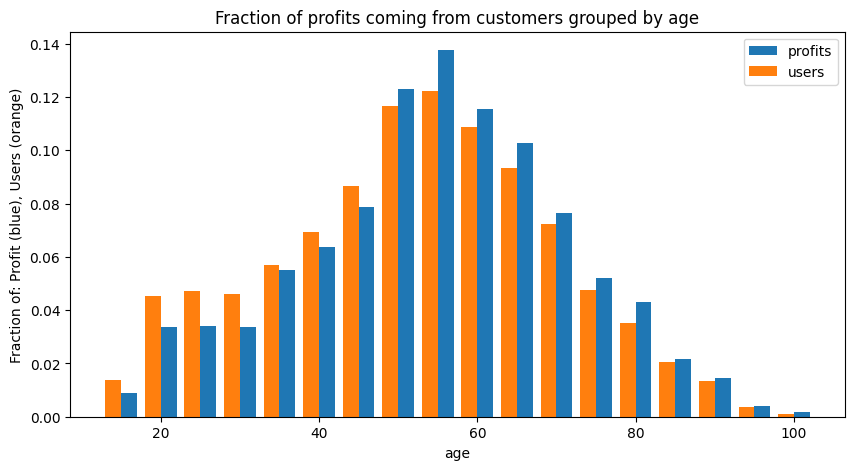

In [123]:
profit_by_group(df_p,grouper="age",binsize=5)

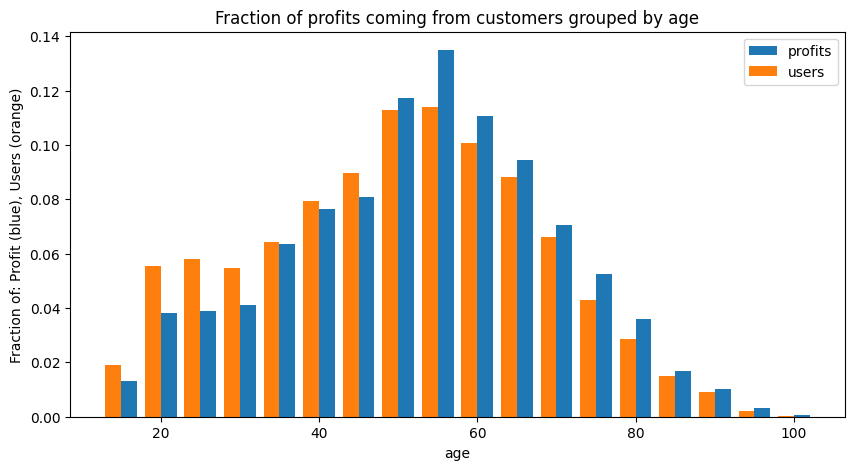

In [142]:
profit_by_group(df_p[df_p.gender=="M"],grouper="age",binsize=5)

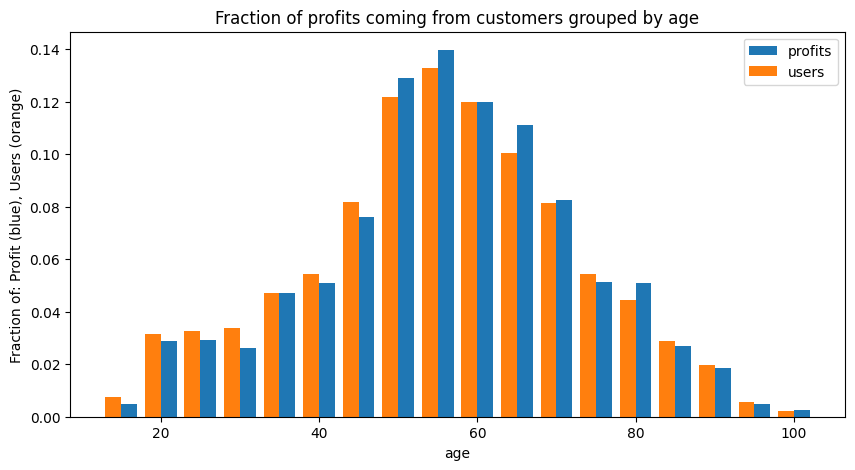

In [143]:
profit_by_group(df_p[df_p.gender=="F"],grouper="age",binsize=5)

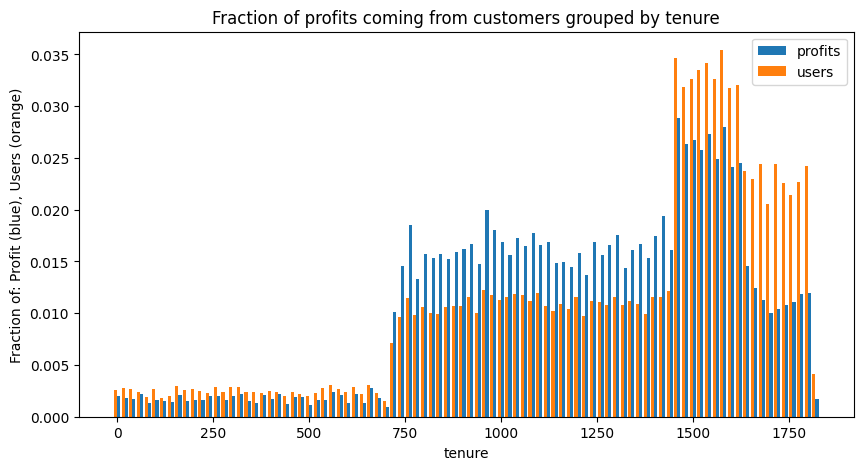

In [124]:
profit_by_group(df_p,grouper="tenure",binsize=20)

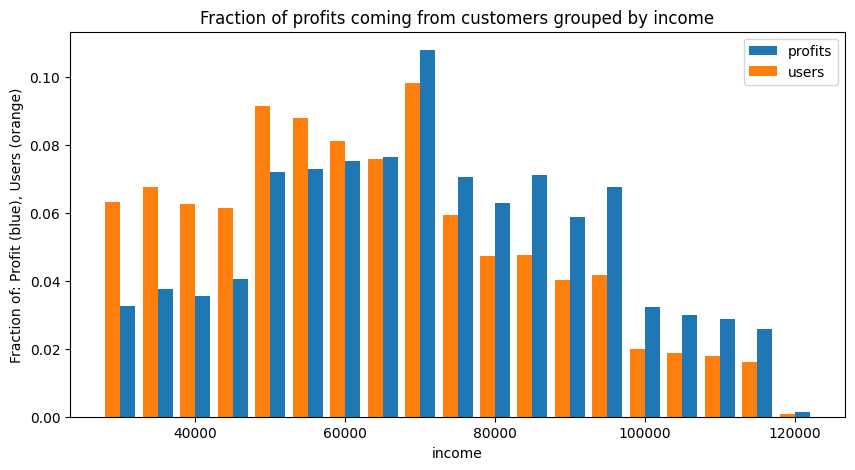

In [125]:
profit_by_group(df_p,grouper="income",binsize=5000)

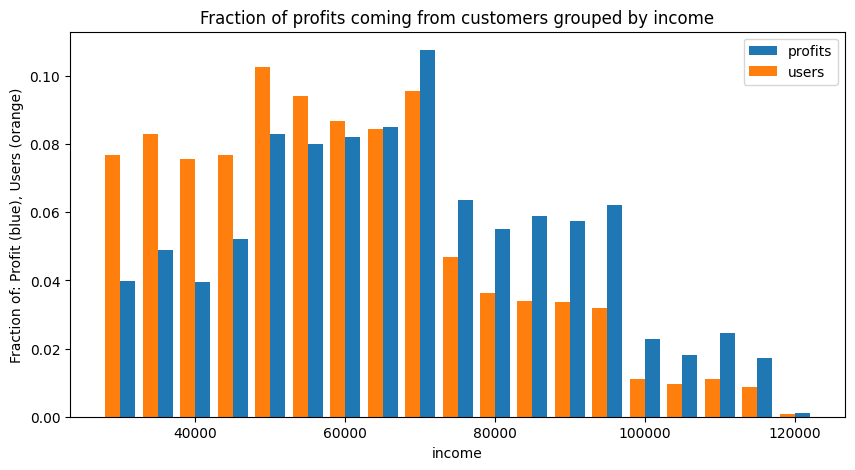

In [144]:
profit_by_group(df_p[df_p.gender=="M"],grouper="income",binsize=5000)

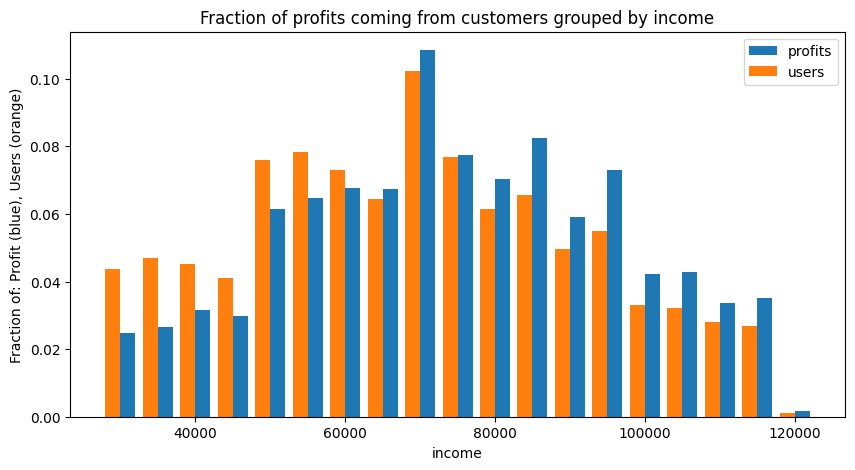

In [145]:
profit_by_group(df_p[df_p.gender=="F"],grouper="income",binsize=5000)

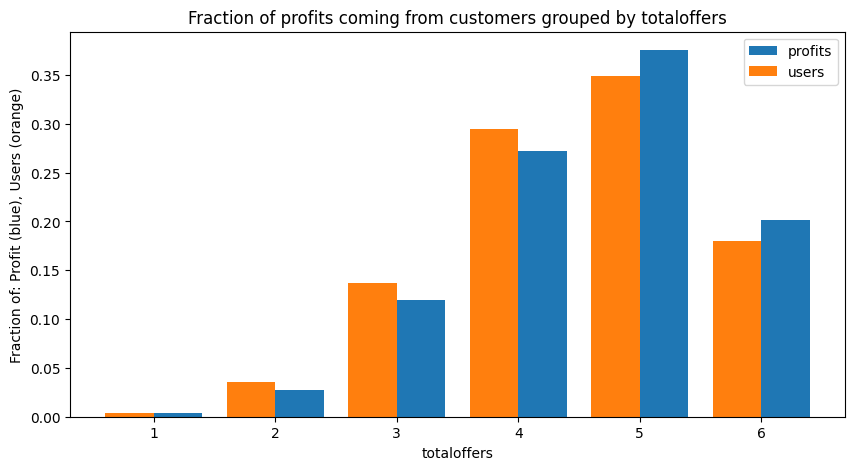

In [126]:
profit_by_group(df_p,grouper="totaloffers",binsize=1)

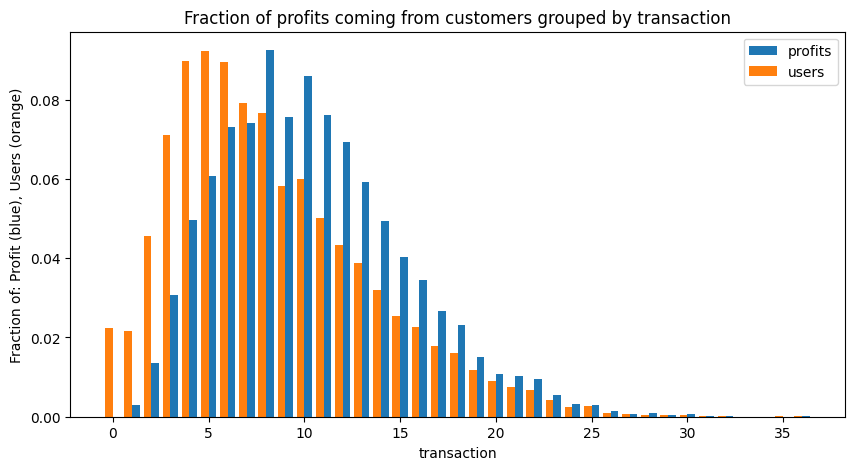

In [152]:
profit_by_group(df_p,grouper="transaction",binsize=1)

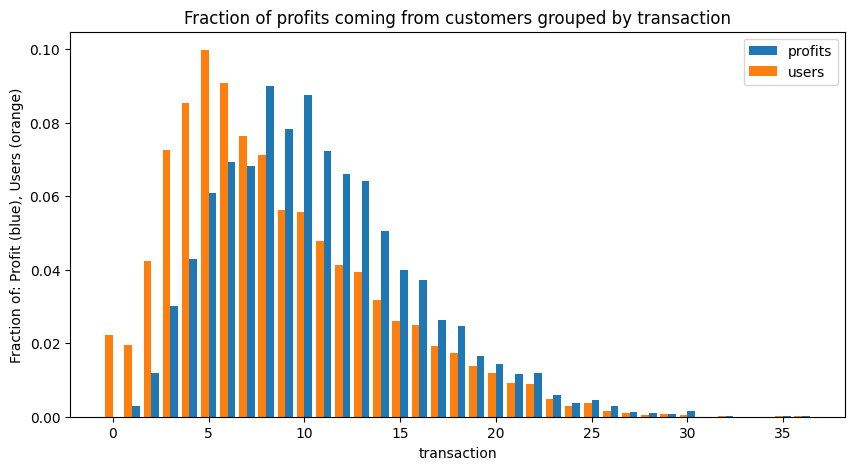

In [154]:
profit_by_group(df_p[df_p.gender=="M"],grouper="transaction",binsize=1)

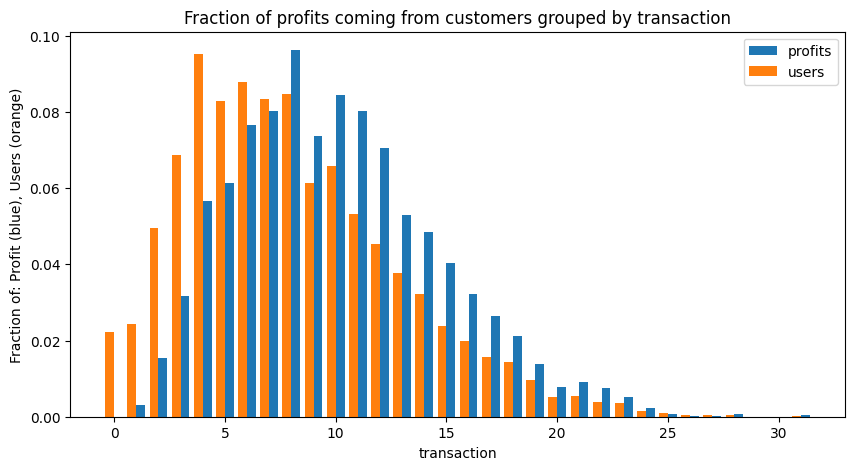

In [155]:
profit_by_group(df_p[df_p.gender=="F"],grouper="transaction",binsize=1)

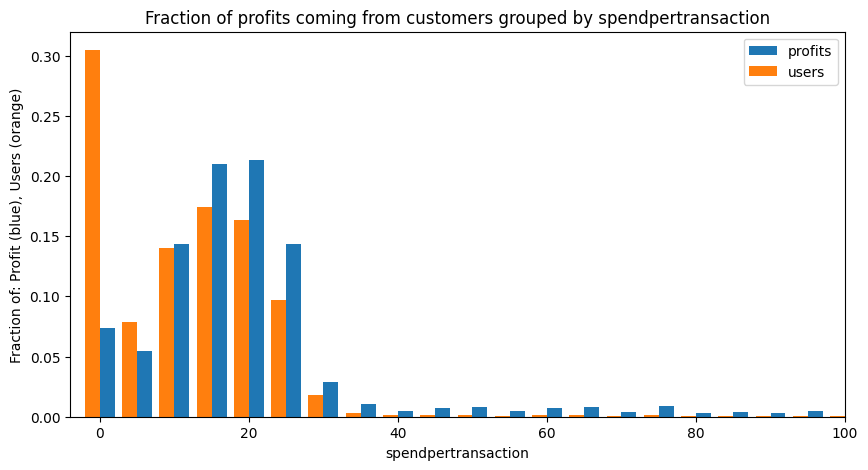

In [165]:
profit_by_group(df_p,grouper="spendpertransaction",binsize=5,ulim=100)

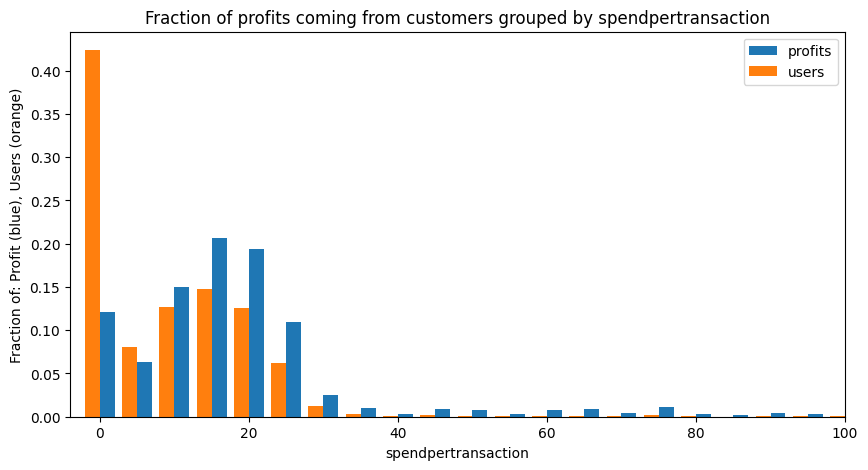

In [166]:
profit_by_group(df_p[df_p.gender=="M"],grouper="spendpertransaction",binsize=5,ulim=100)

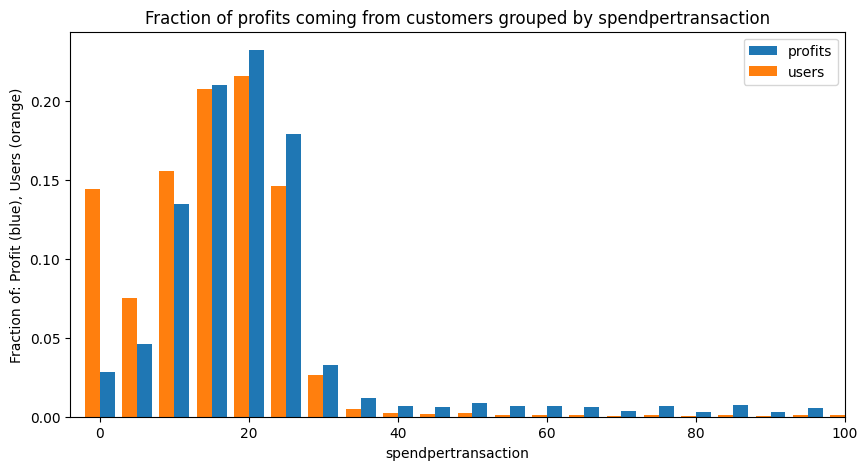

In [167]:
profit_by_group(df_p[df_p.gender=="F"],grouper="spendpertransaction",binsize=5,ulim=100)

In [127]:
df_p.totaloffers.value_counts() / len(df_p)

5    0.349055
4    0.294332
6    0.179690
3    0.136842
2    0.035897
1    0.004184
Name: totaloffers, dtype: float64

In [96]:
df_p.groupby("gender").spend.describe()

count        mean         std  min      25%     50%     75%      max
gender                                                                       
F       6125.0  140.980896  135.544039  0.0  56.8600  116.57  184.96  1327.74
M       8483.0   99.590665  123.223167  0.0  22.7050   63.06  139.20  1608.69
O        212.0  124.323302  118.397436  0.0  43.0275   93.44  179.85   857.75

In [168]:
df_p.groupby("gender").spendpertransaction.describe()

count       mean        std    min        25%        50%        75%  \
gender                                                                         
F       5989.0  18.913292  18.098017  0.240  11.364000  18.044000  23.770000   
M       8294.0  12.612792  14.873939  0.150   3.221667   9.760417  18.928586   
O        204.0  15.121519  12.464966  0.685   7.674773  14.927341  19.580125   

               max  
gender              
F       451.470000  
M       307.930000  
O       142.958333

In [169]:
df_p.groupby("gender").transaction.describe()

count      mean       std  min  25%  50%   75%   max
gender                                                       
F       6125.0  8.059755  4.812048  0.0  4.0  7.0  11.0  31.0
M       8483.0  8.580809  5.423139  0.0  5.0  7.0  12.0  36.0
O        212.0  8.400943  5.258674  0.0  4.0  7.5  12.0  25.0

In [99]:
df_p.groupby("gender").spend.sum()

gender
F    863507.99
M    844827.61
O     26356.54
Name: spend, dtype: float64

In [105]:
pd.options.display.max_rows=100

df_p.groupby("income").tenure.describe()

count         mean         std    min      25%     50%      75%  \
income                                                                      
30000.0    88.0  1344.079545  396.221441  104.0  1128.00  1500.5  1628.00   
31000.0   223.0  1314.470852  427.065693    6.0  1036.50  1493.0  1626.00   
32000.0   216.0  1345.125000  415.700315  101.0  1096.75  1518.0  1627.00   
33000.0   213.0  1348.596244  448.193803   27.0  1170.00  1519.0  1664.00   
34000.0   198.0  1308.712121  446.619852   73.0  1073.75  1495.0  1621.75   
35000.0   205.0  1342.292683  454.908558   39.0  1090.00  1513.0  1665.00   
36000.0   192.0  1342.708333  440.475015   26.0  1095.25  1509.5  1656.00   
37000.0   209.0  1362.110048  411.480024   44.0  1177.00  1505.0  1661.00   
38000.0   185.0  1306.464865  483.937474   20.0  1008.00  1498.0  1669.00   
39000.0   209.0  1285.287081  491.113554    6.0   997.00  1505.0  1641.00   
40000.0   195.0  1251.728205  520.884342    7.0   911.50  1504.0  1618.50   
41000.0   204.0  1357.897059  434.307426   76.0  1169.00  1526.5  1666.25   
42000.0   181.0  1302.751381  477.276008   30.0  1065.00  1504.0  1636.00   
43000.0   169.0  1367.526627  412.081592   86.0  1126.00  1508.0  1664.00   
44000.0   180.0  1309.833333  420.842750  135.0  1043.25  1481.5  1624.25   
45000.0   196.0  1327.295918  447.721244   34.0  1120.75  1492.0  1635.75   
46000.0   181.0  1293.861878  469.498027   51.0  1036.00  1509.0  1634.00   
47000.0   192.0  1340.260417  462.241279   22.0  1097.00  1519.5  1677.25   
48000.0   186.0  1334.725806  432.776373   26.0  1032.00  1515.5  1654.00   
49000.0   157.0  1293.528662  442.854603  117.0   988.00  1482.0  1611.00   
50000.0   253.0  1307.189723  438.496036   29.0  1009.00  1480.0  1618.00   
51000.0   268.0  1310.638060  445.412605   15.0  1025.75  1497.5  1636.00   
52000.0   281.0  1292.441281  452.437736   11.0  1025.00  1467.0  1636.00   
53000.0   282.0  1277.315603  436.400584   70.0   975.50  1459.0  1622.25   
54000.0   272.0  1307.018382  443.376590   13.0  1041.25  1473.5  1622.00   
55000.0   254.0  1276.452756  435.450523    1.0   989.00  1461.5  1621.75   
56000.0   281.0  1273.167260  454.095794   10.0   986.00  1447.0  1628.00   
57000.0   288.0  1293.465278  461.335177   21.0  1077.75  1476.0  1627.75   
58000.0   239.0  1287.263598  442.877074    2.0  1024.00  1479.0  1623.00   
59000.0   243.0  1278.724280  466.910757   41.0  1013.50  1463.0  1627.00   
60000.0   251.0  1258.617530  449.344088   16.0   909.50  1462.0  1601.00   
61000.0   258.0  1292.465116  435.444271   10.0  1008.25  1461.0  1634.75   
62000.0   229.0  1306.576419  440.292924    4.0   971.00  1490.0  1629.00   
63000.0   206.0  1320.504854  429.928704   30.0  1044.50  1493.0  1625.00   
64000.0   258.0  1316.988372  403.358676   86.0  1024.25  1466.0  1624.00   
65000.0   238.0  1321.857143  448.443088    1.0  1116.00  1487.5  1640.75   
66000.0   222.0  1195.500000  467.040589    5.0   903.75  1308.0  1581.75   
67000.0   242.0  1340.466942  435.232862   11.0  1141.00  1520.0  1640.75   
68000.0   228.0  1259.622807  461.072297   57.0   941.25  1471.5  1609.25   
69000.0   196.0  1248.484694  456.312865    0.0  1000.75  1420.0  1579.25   
70000.0   269.0  1342.728625  419.829182   33.0  1080.00  1509.0  1641.00   
71000.0   294.0  1332.292517  387.667299   51.0  1097.00  1462.5  1606.50   
72000.0   296.0  1320.922297  394.667237   28.0  1046.25  1435.0  1619.00   
73000.0   314.0  1294.675159  419.819377    3.0  1037.75  1459.0  1606.75   
74000.0   282.0  1325.861702  405.305717    1.0  1076.25  1477.0  1609.25   
75000.0   243.0  1304.423868  378.457512   17.0  1048.50  1388.0  1608.00   
76000.0   157.0  1326.267516  383.454814   56.0  1020.00  1464.0  1613.00   
77000.0   158.0  1281.943038  366.296272   15.0  1010.25  1318.0  1592.50   
78000.0   157.0  1288.898089  359.657497  264.0   984.00  1338.0  1597.00   
79000.0   166.0  1264.036145  401.700716   39.0   961.00  1369.0  1587.25   
80000.

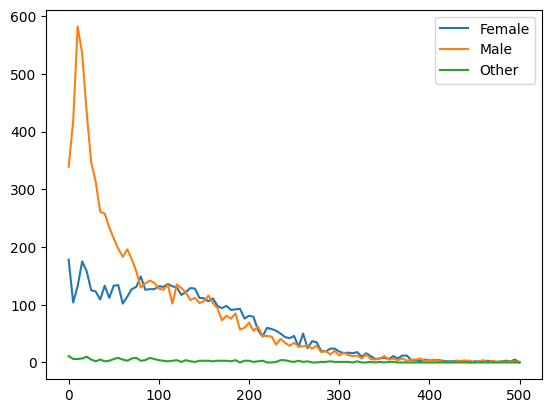

In [139]:
df_p["spend_bin"] = (df_p.spend // 5) * 5
df_genderspend = df_p[df_p.spend < 501].pivot_table(index = ["spend_bin",], columns = "gender", aggfunc = "size", fill_value = 0).reset_index()

plt.plot(df_genderspend.spend_bin, df_genderspend.F, label="Female")
plt.plot(df_genderspend.spend_bin, df_genderspend.M, label="Male")
plt.plot(df_genderspend.spend_bin, df_genderspend.O, label="Other")
plt.legend()


## Some notes so far from trying to describe the overall data, ignoring promotions:

- tenure looks like it is pretty random between ages and incomes, AND overall spending. will be interesting to see if it correlates to offers
- total offers received seems pretty randomized as well. will be useful to compare the types of offers
- spending doesn't vary THAT widely by age.
- spending habits appear to be pretty different between men and women.
    - men are more likely to be low spenders. The surplus of men in our dataset all seems to be at the low end.
        - This dataset is meant to resemble app users, NOT the overall population visiting starbucks. This may indicate that men are more willing to install an app, even if they are not a "superspender". Women who install the app are far more likely to be "superspenders".
    - men and women who use the starbucks app visit starbucks same frequency. However, the median spend per transaction is nearly double for women. 
    - 
    - this means our profit base for men (where most of our profit comes from) is a smaller subset of men, focues on the high spenders. Our profit base for women is larger. 
    - strategically, we will be targeting a smaller group of men than women (in terms of ratios). We may expect a more distinct profile for a male who spends a lot at starbucks.
        - The more I look at the data, it seems like there are two groups of men - low spenders and high spenders - that may require different strategies. The profit base for women is a little more uniform.

- now looking at two items:
    - what does our best customer look like? this is going to be spend/customer. These are the kind of people we want to reach out to for our rewards program.
    - from our existing userbase, where does our profit come from? Is it many people, or a small subgroup? Either way, how do we incentivize this group to spend more, as pushing this group should give us the best improvement to profits.


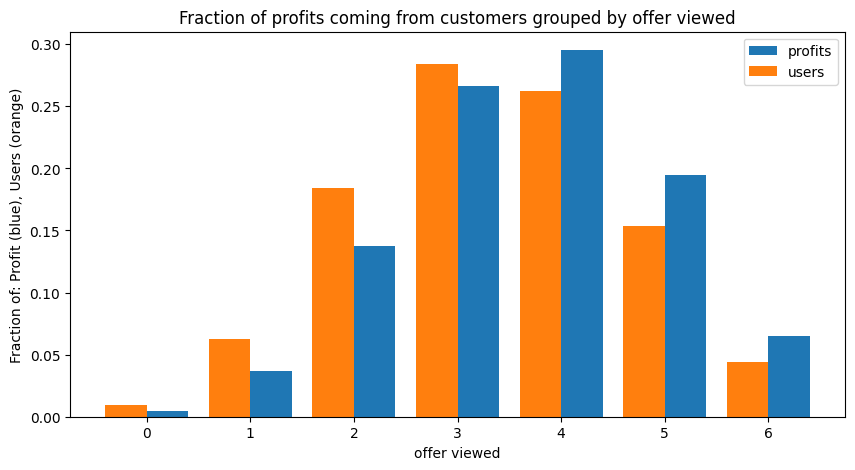

In [146]:
profit_by_group(df_p,grouper="offer viewed",binsize=1)

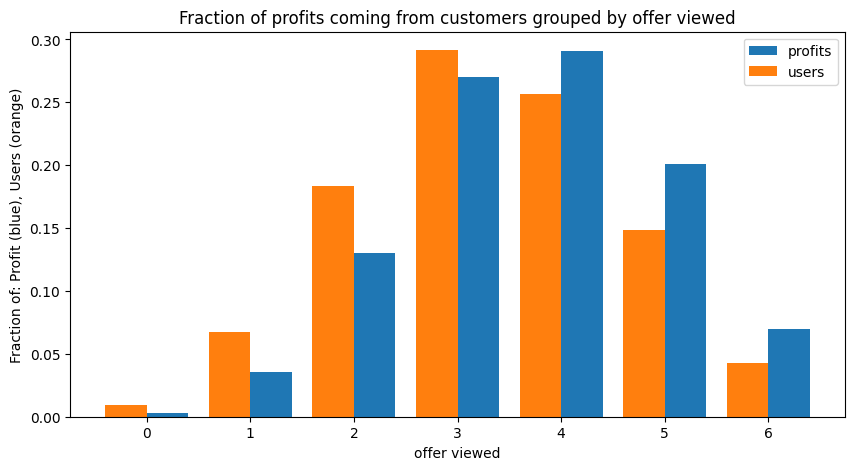

In [147]:
profit_by_group(df_p[df_p.gender=="M"],grouper="offer viewed",binsize=1)

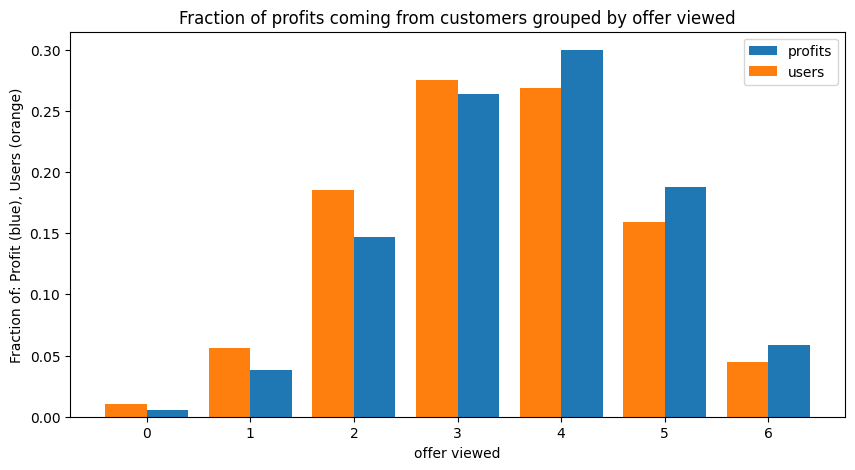

In [148]:
profit_by_group(df_p[df_p.gender=="F"],grouper="offer viewed",binsize=1)

### count of offers viewed does not disproportinately affect profits. ie, we are not making disproportinately more money from users who view our offers.

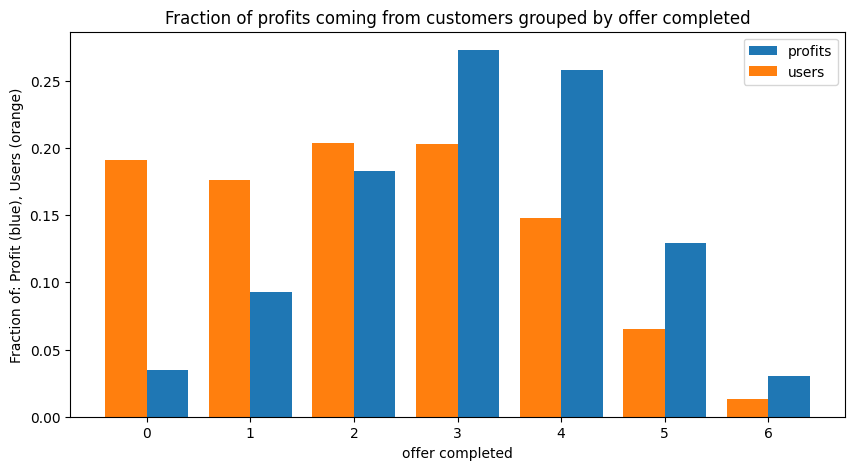

In [149]:
profit_by_group(df_p,grouper="offer completed",binsize=1)

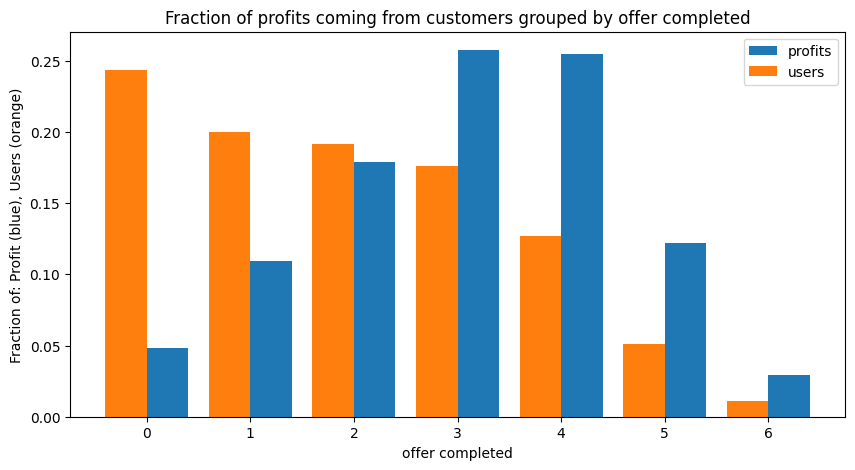

In [150]:
profit_by_group(df_p[df_p.gender=="M"],grouper="offer completed",binsize=1)

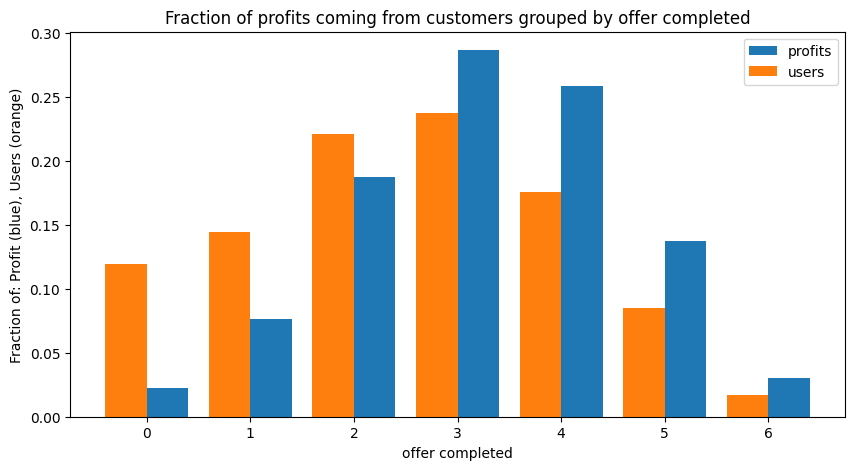

In [151]:
profit_by_group(df_p[df_p.gender=="F"],grouper="offer completed",binsize=1)

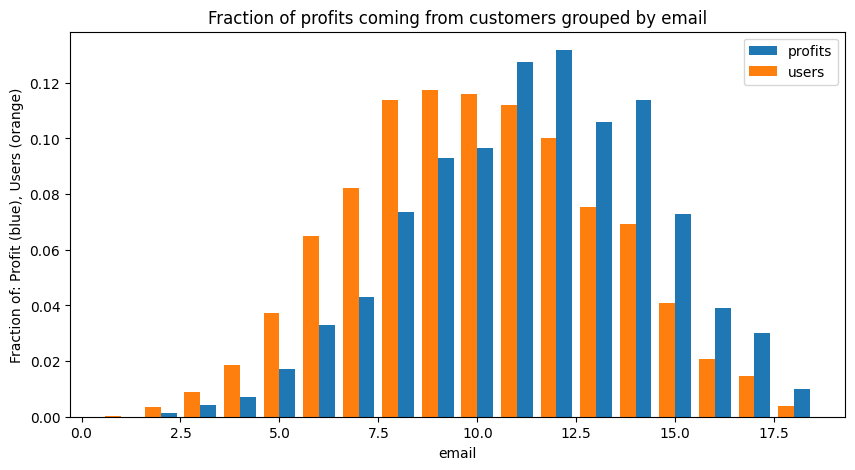

In [174]:
profit_by_group(df_p,grouper="email",binsize=1)

In [175]:
df_p.head()

offername                            person gender  age   income  tenure  \
0          0009655768c64bdeb2e877511632db8f      M   33  72000.0    1362   
1          0011e0d4e6b944f998e987f904e8c1e5      O   40  57000.0    1625   
2          0020c2b971eb4e9188eac86d93036a77      F   59  90000.0     949   
3          0020ccbbb6d84e358d3414a3ff76cffd      F   24  60000.0    1201   
4          003d66b6608740288d6cc97a6903f4f0      F   26  73000.0    1423   

offername  bogo_5_10_10  bogo_5_5_5  bogo_7_10_10  bogo_7_5_5  \
0                     0           1             0           0   
1                     0           0             0           1   
2                     1           0             1           0   
3                     0           1             0           1   
4                     0           0             0           0   

offername  discount_10_10_2  ...  offer viewed  transaction   spend  \
0                         1  ...             4            8  127.60   
1                         0  ...             5            5   79.46   
2                         2  ...             3            8  196.86   
3                         0  ...             4           12  154.05   
4                         2  ...             4           18   48.34   

offername  totaloffers  spendpertransaction  mobile   web  social  email   bin  
0                    5            15.950000    12.0  10.0     8.0   12.0  12.0  
1                    5            15.892000    10.0  11.0     5.0   13.0  13.0  
2                    5            24.607500    11.0   8.0    11.0   11.0  11.0  
3                    4            12.837500    11.0   9.0     8.0   11.0  11.0  
4                    5             2.685556    10.0  10.0     8.0   12.0  12.0  

[5 rows x 27 columns]

In [177]:
df_p.columns

Index(['person', 'gender', 'age', 'income', 'tenure', 'bogo_5_10_10',
       'bogo_5_5_5', 'bogo_7_10_10', 'bogo_7_5_5', 'discount_10_10_2',
       'discount_10_20_5', 'discount_7_10_2', 'discount_7_7_3',
       'informational_3_0_0', 'informational_4_0_0', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'spend', 'totaloffers',
       'spendpertransaction', 'mobile', 'web', 'social', 'email', 'bin'],
      dtype='object', name='offername')

In [192]:
def show_corr(df):
    df_p_corr = df[[
        "age",
        "income",
        "tenure",
        'offer received',
        "offer viewed",
        "offer completed",
        "transaction",
        "spend",
        "spendpertransaction",
        "mobile",
        "web",
        "social",
        "email",
        "totaloffers"
    ]]

    corr = df_p_corr.corr()
    return corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

show_corr(df_p)

In [193]:
show_corr(df_p[df_p.gender=="M"])

In [194]:
show_corr(df_p[df_p.gender=="F"])

# Offer analysis

In [195]:
df.head()

person           event  time gender  age  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   0.0      F   75   
1  a03223e636434f42ac4c3df47e8bac43  offer received   0.0   None  118   
2  e2127556f4f64592b11af22de27a7932  offer received   0.0      M   68   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   0.0   None  118   
4  68617ca6246f4fbc85e91a2a49552598  offer received   0.0   None  118   

     income  tenure  amount         offername                      channels  \
0  100000.0    1380     0.0        bogo_7_5_5          [web, email, mobile]   
1       NaN    1467     0.0  discount_10_20_5                  [web, email]   
2   70000.0    1732     0.0   discount_7_10_2          [web, email, mobile]   
3       NaN    1519     0.0  discount_10_10_2  [web, email, mobile, social]   
4       NaN    1526     0.0      bogo_5_10_10  [web, email, mobile, social]   

   reward  difficulty  duration offer_type  mobile  web  social  email  
0     5.0         5.0       7.0       bogo     1.0  1.0     0.0    1.0  
1     5.0        20.0      10.0   discount     0.0  1.0     0.0    1.0  
2     2.0        10.0       7.0   discount     1.0  1.0     0.0    1.0  
3     2.0        10.0      10.0   discount     1.0  1.0     1.0    1.0  
4    10.0        10.0       5.0       bogo     1.0  1.0     1.0    1.0

In [196]:
offers = df[df.event == "offer received"][df.duration + df.time < 30]

In [197]:
offers

person           event  time gender  age  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   0.0      F   75   
1       a03223e636434f42ac4c3df47e8bac43  offer received   0.0   None  118   
2       e2127556f4f64592b11af22de27a7932  offer received   0.0      M   68   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   0.0   None  118   
4       68617ca6246f4fbc85e91a2a49552598  offer received   0.0   None  118   
...                                  ...             ...   ...    ...  ...   
257871  1966fa40d2f84620b2b1b9b64f8e0209  offer received  24.0      M   84   
257878  ca45ee1883624304bac1e4c8a114f045  offer received  24.0   None  118   
257880  f924927e7f844ecebf87eef93f4d2688  offer received  24.0      M   47   
257881  a57890c3bbb7463e9018abb7fecadb15  offer received  24.0      M   57   
257886  e4052622e5ba45a8b96b59aba68cf068  offer received  24.0      F   62   

          income  tenure  amount            offername  \
0       100000.0    1380     0.0           bogo_7_5_5   
1            NaN    1467     0.0     discount_10_20_5   
2        70000.0    1732     0.0      discount_7_10_2   
3            NaN    1519     0.0     discount_10_10_2   
4            NaN    1526     0.0         bogo_5_10_10   
...          ...     ...     ...                  ...   
257871   93000.0    1066     0.0           bogo_5_5_5   
257878       NaN    1680     0.0  informational_4_0_0   
257880   93000.0    1035     0.0  informational_3_0_0   
257881   77000.0    1626     0.0  informational_3_0_0   
257886   82000.0    1454     0.0  informational_4_0_0   

                            channels  reward  difficulty  duration  \
0               [web, email, mobile]     5.0         5.0       7.0   
1                       [web, email]     5.0        20.0      10.0   
2               [web, email, mobile]     2.0        10.0       7.0   
3       [web, email, mobile, social]     2.0        10.0      10.0   
4       [web, email, mobile, social]    10.0        10.0       5.0   
...                              ...     ...         ...       ...   
257871  [web, email, mobile, social]     5.0         5.0       5.0   
257878          [web, email, mobile]     0.0         0.0       4.0   
257880       [email, mobile, social]     0.0         0.0       3.0   
257881       [email, mobile, social]     0.0         0.0       3.0   
257886          [web, email, mobile]     0.0         0.0       4.0   

           offer_type  mobile  web  social  email  
0                bogo     1.0  1.0     0.0    1.0  
1            discount     0.0  1.0     0.0    1.0  
2            discount     1.0  1.0     0.0    1.0  
3            discount     1.0  1.0     1.0    1.0  
4                bogo     1.0  1.0     1.0    1.0  
...               ...     ...  ...     ...    ...  
257871           bogo     1.0  1.0     1.0    1.0  
257878  informational     1.0  1.0     0.0    1.0  
257880  informational     1.0  0.0     1.0    1.0  
257881  informational     1.0  0.0     1.0    1.0  
257886  informational     1.0  1.0     0.0    1.0  

[66041 rows x 18 columns]

In [198]:
completes = df[df.event == "offer completed"]

In [199]:
completes

person            event   time gender  age  \
12658   9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed   0.00      M   42   
12672   fe97aa22dd3e48c8b143116a8403dd52  offer completed   0.00      F   39   
12679   629fc02d56414d91bca360decdfa9288  offer completed   0.00      M   52   
12692   676506bad68e4161b9bbaffeb039626b  offer completed   0.00      M   37   
12697   8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed   0.00      M   48   
...                                  ...              ...    ...    ...  ...   
306475  0c027f5f34dd4b9eba0a25785c611273  offer completed  29.75      M   56   
306497  a6f84f4e976f44508c358cc9aba6d2b3  offer completed  29.75   None  118   
306506  b895c57e8cd047a8872ce02aa54759d6  offer completed  29.75   None  118   
306509  8431c16f8e1d440880db371a68f82dd0  offer completed  29.75      M   39   
306527  24f56b5e1849462093931b164eb803b5  offer completed  29.75      F   48   

         income  tenure  amount         offername  \
12658   96000.0     902     0.0   discount_7_10_2   
12672   67000.0    1602     0.0  discount_10_10_2   
12679   72000.0    1772     0.0        bogo_7_5_5   
12692   92000.0    1386     0.0      bogo_7_10_10   
12697   62000.0     766     0.0      bogo_5_10_10   
...         ...     ...     ...               ...   
306475  61000.0    1548     0.0    discount_7_7_3   
306497      NaN    1267     0.0    discount_7_7_3   
306506      NaN    1276     0.0  discount_10_10_2   
306509  39000.0    1794     0.0  discount_10_10_2   
306527  80000.0    1613     0.0  discount_10_10_2   

                            channels  reward  difficulty  duration offer_type  \
12658           [web, email, mobile]     2.0        10.0       7.0   discount   
12672   [web, email, mobile, social]     2.0        10.0      10.0   discount   
12679           [web, email, mobile]     5.0         5.0       7.0       bogo   
12692        [email, mobile, social]    10.0        10.0       7.0       bogo   
12697   [web, email, mobile, social]    10.0        10.0       5.0       bogo   
...                              ...     ...         ...       ...        ...   
306475  [web, email, mobile, social]     3.0         7.0       7.0   discount   
306497  [web, email, mobile, social]     3.0         7.0       7.0   discount   
306506  [web, email, mobile, social]     2.0        10.0      10.0   discount   
306509  [web, email, mobile, social]     2.0        10.0      10.0   discount   
306527  [web, email, mobile, social]     2.0        10.0      10.0   discount   

        mobile  web  social  email  
12658      1.0  1.0     0.0    1.0  
12672      1.0  1.0     1.0    1.0  
12679      1.0  1.0     0.0    1.0  
12692      1.0  0.0     1.0    1.0  
12697      1.0  1.0     1.0    1.0  
...        ...  ...     ...    ...  
306475     1.0  1.0     1.0    1.0  
306497     1.0  1.0     1.0    1.0  
306506     1.0  1.0     1.0    1.0  
306509     1.0  1.0     1.0    1.0  
306527     1.0  1.0     1.0    1.0  

[33579 rows x 18 columns]

In [218]:
df[df.offer_type=="bogo"].groupby(["event","reward"]).reward.count()

event            reward
offer completed  5.0        8650
                 10.0       7019
offer received   5.0       15248
                 10.0      15251
offer viewed     5.0       11435
                 10.0      14014
Name: reward, dtype: int64

In [221]:
df.groupby(["event","reward"]).duration.count()

event            reward
offer completed  2.0        9334
                 3.0        5156
                 5.0       12070
                 10.0       7019
offer received   0.0       15235
                 2.0       15229
                 3.0        7646
                 5.0       22916
                 10.0      15251
offer viewed     0.0       10831
                 2.0       11445
                 3.0        7337
                 5.0       14098
                 10.0      14014
Name: duration, dtype: int64

In [208]:
df[df.offer_type=="informational"].groupby(["event","duration"]).duration.count()

event           duration
offer received  3.0         7618
                4.0         7617
offer viewed    3.0         6687
                4.0         4144
Name: duration, dtype: int64

# ML strategy

My exploration suggests that, purely in terms of customer qualities, there are "low spenders" (less than $10 per transaction) and high spenders. This latter group is MUCH more important to us in terms of profits, so we want to understand them better.

We will focus only on the high spending crowd, which is about half the group but almost 90% of our profit base (for rewards program users). How do we best energize this base?


array(['bogo', 'discount', 'informational', nan], dtype=object)

In [215]:
df_p[df_p["spendpertransaction"]>=10].shape

(8932, 27)

In [223]:
pd.options.display.max_columns=300
df_p.head()

offername                            person gender  age   income  tenure  \
0          0009655768c64bdeb2e877511632db8f      M   33  72000.0    1362   
1          0011e0d4e6b944f998e987f904e8c1e5      O   40  57000.0    1625   
2          0020c2b971eb4e9188eac86d93036a77      F   59  90000.0     949   
3          0020ccbbb6d84e358d3414a3ff76cffd      F   24  60000.0    1201   
4          003d66b6608740288d6cc97a6903f4f0      F   26  73000.0    1423   

offername  bogo_5_10_10  bogo_5_5_5  bogo_7_10_10  bogo_7_5_5  \
0                     0           1             0           0   
1                     0           0             0           1   
2                     1           0             1           0   
3                     0           1             0           1   
4                     0           0             0           0   

offername  discount_10_10_2  discount_10_20_5  discount_7_10_2  \
0                         1                 0                1   
1                         0                 1                0   
2                         2                 0                0   
3                         0                 0                0   
4                         2                 1                0   

offername  discount_7_7_3  informational_3_0_0  informational_4_0_0  \
0                       0                    1                    1   
1                       1                    1                    1   
2                       0                    1                    0   
3                       1                    1                    0   
4                       0                    1                    1   

offername  offer completed  offer received  offer viewed  transaction  bogo  \
0                        3               5             4            8     1   
1                        3               5             5            5     1   
2                        3               5             3            8     2   
3                        3               4             4           12     2   
4                        3               5             4           18     0   

offername  discount  informational   spend  totaloffers  spendpertransaction  \
0                 2              2  127.60            5            15.950000   
1                 2              2   79.46            5            15.892000   
2                 2              1  196.86            5            24.607500   
3                 1              1  154.05            4            12.837500   
4                 3              2   48.34            5             2.685556   

offername  mobile   web  social  email  
0            12.0  10.0     8.0   12.0  
1            10.0  11.0     5.0   13.0  
2            11.0   8.0    11.0   11.0  
3            11.0   9.0     8.0   11.0  
4            10.0  10.0     8.0   12.0

In [261]:
df_ml = df_p[df_p["spendpertransaction"]>=10][df_p.spend <= 400][[
    "bogo",
    "discount",
    "informational",
    "totaloffers",
    "mobile",
    "web",
    "social",
    "email",
    "spend",
    "spendpertransaction"
]]

In [262]:
corr = df_ml.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

## Spend and spendpertransaction dont seem too driven by these values, but spend looks a little better. Let's try that.

In [263]:
df_ml.groupby(["bogo",
    "discount",
    "informational",
    "totaloffers",
    "mobile",
    "web",
    "social",
    "email",]).spend.describe()

count  \
bogo discount informational totaloffers mobile web  social email          
0    0        1             1           2.0    0.0  2.0    2.0      4.0   
                                               2.0  0.0    2.0      2.0   
              2             2           2.0    2.0  0.0    2.0      2.0   
                                        4.0    0.0  4.0    4.0      6.0   
                                               2.0  2.0    4.0      3.0   
...                                                                 ...   
6    0        0             6           15.0   12.0 13.0   15.0     1.0   
                                        16.0   7.0  9.0    16.0     1.0   
                                               16.0 11.0   16.0     1.0   
                                        17.0   17.0 17.0   17.0     1.0   
                                        18.0   9.0  12.0   18.0     1.0   

                                                                     mean  \
bogo discount informational totaloffers mobile web  social email            
0    0        1             1           2.0    0.0  2.0    2.0    117.525   
                                               2.0  0.0    2.0     38.065   
              2             2           2.0    2.0  0.0    2.0     42.055   
                                        4.0    0.0  4.0    4.0     96.915   
                                               2.0  2.0    4.0    106.490   
...                                                                   ...   
6    0        0             6           15.0   12.0 13.0   15.0   197.080   
                                        16.0   7.0  9.0    16.0   103.600   
                                               16.0 11.0   16.0    59.160   
                                        17.0   17.0 17.0   17.0   156.660   
                                        18.0   9.0  12.0   18.0   143.330   

                                                                        std  \
bogo discount informational totaloffers mobile web  social email              
0    0        1             1           2.0    0.0  2.0    2.0    73.241539   
                                               2.0  0.0    2.0     2.524371   
              2             2           2.0    2.0  0.0    2.0    12.381440   
                                        4.0    0.0  4.0    4.0    35.483858   
                                               2.0  2.0    4.0    34.540109   
...                                                                     ...   
6    0        0             6           15.0   12.0 13.0   15.0         NaN   
                                        16.0   7.0  9.0    16.0         NaN   
                                               16.0 11.0   16.0         NaN   
                                        17.0   17.0 17.0   17.0         NaN   
                                        18.0   9.0  12.0   18.0         NaN   

                                                                     min  \
bogo discount informational totaloffers mobile web  social email           
0    0        1             1           2.0    0.0  2.0    2.0     25.12   
                                               2.0  0.0    2.0     36.28   
              2             2           2.0    2.0  0.0    2.0     33.30   
                                        4.0    0.0  4.0    4.0     65.18   
                                               2.0  2.0    4.0     67.03   
...                                                                  ...   
6    0        0             6           15.0   12.0 13.0   15.0   197.08   
                                        16.0   7.0  9.0    16.0   103.60   
                                               16.0 11.0   16.0    59.16   
                                        17.0   17.0 17.0   17.0   156.66   
                                        18.0   9.0  12.0   18.0   143.33   

                                                                       

array([[<AxesSubplot:title={'center':'spend'}>]], dtype=object)

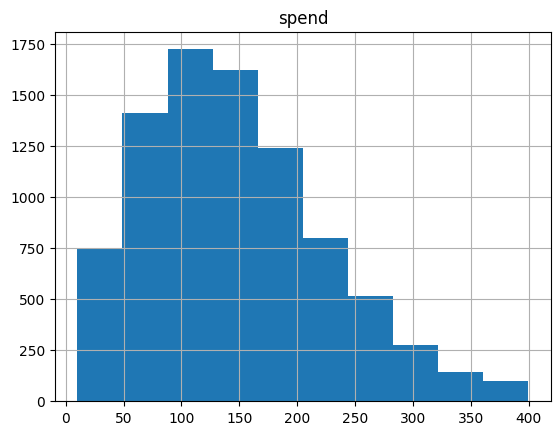

In [264]:
df_ml.hist("spend")

In [265]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

X = df_ml[["bogo",
    "discount",
    "informational",
    "totaloffers",
    "mobile",
    "web",
    "social",
    "email"]]

y = df_ml["spend"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [266]:
# regressor = DecisionTreeRegressor(max_depth=5)
# regressor = LinearRegression()
regressor = GradientBoostingRegressor()

scores = cross_val_score(regressor, X, y, cv=10)
scores


array([0.21231584, 0.19309111, 0.21375136, 0.19148706, 0.23146143,
       0.18508321, 0.21205898, 0.25210829, 0.21205805, 0.24761766])

In [267]:
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)
    print(r2_score(y_test, regressor.predict(X_test)))


-0.3891026713431478
-0.3360078155820838
-0.23261874256285187
-0.2862012296167431
-0.2860396117534105


## There are poor results modeling customers based on what they receive. Maybe a better view is per-offer?

### make an offer table
- profile of who got it
- was it viewed? completed? 

### paired differences - another option
- try to pair off my customers
  - find like customers (gender, income, tenure) who had different offer profiles and compare their spending.
  - do this for men and women separately


In [290]:
df_p.head()

offername                            person gender  age   income  tenure  \
0          0009655768c64bdeb2e877511632db8f      M   33  72000.0    1362   
1          0011e0d4e6b944f998e987f904e8c1e5      O   40  57000.0    1625   
2          0020c2b971eb4e9188eac86d93036a77      F   59  90000.0     949   
3          0020ccbbb6d84e358d3414a3ff76cffd      F   24  60000.0    1201   
4          003d66b6608740288d6cc97a6903f4f0      F   26  73000.0    1423   

offername  bogo_5_10_10  bogo_5_5_5  bogo_7_10_10  bogo_7_5_5  \
0                     0           1             0           0   
1                     0           0             0           1   
2                     1           0             1           0   
3                     0           1             0           1   
4                     0           0             0           0   

offername  discount_10_10_2  discount_10_20_5  discount_7_10_2  \
0                         1                 0                1   
1                         0                 1                0   
2                         2                 0                0   
3                         0                 0                0   
4                         2                 1                0   

offername  discount_7_7_3  informational_3_0_0  informational_4_0_0  \
0                       0                    1                    1   
1                       1                    1                    1   
2                       0                    1                    0   
3                       1                    1                    0   
4                       0                    1                    1   

offername  offer completed  offer received  offer viewed  transaction  bogo  \
0                        3               5             4            8     1   
1                        3               5             5            5     1   
2                        3               5             3            8     2   
3                        3               4             4           12     2   
4                        3               5             4           18     0   

offername  discount  informational   spend  totaloffers  spendpertransaction  \
0                 2              2  127.60            5            15.950000   
1                 2              2   79.46            5            15.892000   
2                 2              1  196.86            5            24.607500   
3                 1              1  154.05            4            12.837500   
4                 3              2   48.34            5             2.685556   

offername  mobile   web  social  email  
0            12.0  10.0     8.0   12.0  
1            10.0  11.0     5.0   13.0  
2            11.0   8.0    11.0   11.0  
3            11.0   9.0     8.0   11.0  
4            10.0  10.0     8.0   12.0

In [291]:
# paired difference modeling:
df_pair = df_p[df_p["spendpertransaction"]>=10][df_p.spend <= 400][[
    "age",
    "income",
    "tenure",
    "bogo",
    "discount",
    "informational",
    "totaloffers",
    "offer viewed",
    "offer completed",
    "mobile",
    "web",
    "social",
    "email",
    "spend",
    "spendpertransaction",
    "transaction"
]]
df_pair["income_bin"] = (df_pair.income // 10000)*10000
df_pair["age_bin"] = (df_pair.age // 10) * 10
df_pair["tenure_bin"] = (df_pair.tenure // 250) * 250

In [292]:
# within each group, get the means for spend, transaction, and spendpertransaction. report these back to df_pair. do corr on these.

df_summary = df_pair.groupby(["income_bin","age_bin"])[["spend","transaction","spendpertransaction"]].mean()
df_std = df_pair.groupby(["income_bin","age_bin"])[["spend","transaction","spendpertransaction"]].std()
df_groupsize = df_pair.groupby(["income_bin","age_bin"])["spend"].count()

df_summary["spend_std"] = df_std.spend
df_summary["transaction_std"] = df_std.transaction
df_summary["spendpertransaction_std"] = df_std.spendpertransaction
df_summary["groupsize"] = df_groupsize

df_lookup_bins = df_summary.reset_index()

In [293]:
df_paired_means = df_pair.merge(df_lookup_bins, how='left', left_on=["age_bin","income_bin"], right_on=["age_bin","income_bin"], suffixes = ("","_mean"))
df_paired_means = df_paired_means[[
    "income_bin",
    "age_bin",
    "bogo",
    "discount",
    "informational",
    "totaloffers",
    "offer viewed",
    "offer completed",
    "mobile",
    "web",
    "social",
    "email",
    "spend",
    "spend_mean",
    "spend_std",
    "transaction",
    "transaction_mean",
    "transaction_std",
    "spendpertransaction",
    "spendpertransaction_mean",
    "spendpertransaction_std",
]]
df_paired_means["spend_rel"] = df_paired_means.spend - df_paired_means.spend_mean
df_paired_means["transaction_rel"] = df_paired_means.transaction - df_paired_means.transaction_mean
df_paired_means["spendpertransaction_rel"] = df_paired_means.spendpertransaction - df_paired_means.spendpertransaction_mean

df_paired_means

offername  income_bin  age_bin  bogo  discount  informational  totaloffers  \
0             70000.0       30     1         2              2            5   
1             50000.0       40     1         2              2            5   
2             90000.0       50     2         2              1            5   
3             60000.0       20     2         1              1            4   
4             70000.0       50     1         1              1            3   
...               ...      ...   ...       ...            ...          ...   
8566          70000.0       70     2         3              1            6   
8567          70000.0       60     1         2              2            5   
8568          80000.0       60     1         0              2            3   
8569          90000.0       50     5         1              0            6   
8570          60000.0       40     1         5              0            6   

offername  offer viewed  offer completed  mobile   web  social  email   spend  \
0                     4                3    12.0  10.0     8.0   12.0  127.60   
1                     5                3    10.0  11.0     5.0   13.0   79.46   
2                     3                3    11.0   8.0    11.0   11.0  196.86   
3                     4                3    11.0   9.0     8.0   11.0  154.05   
4                     2                2     7.0   7.0     6.0    7.0  138.36   
...                 ...              ...     ...   ...     ...    ...     ...   
8566                  2                3     8.0  10.0     3.0   11.0   63.49   
8567                  5                3    13.0   6.0     7.0   13.0  234.05   
8568                  3                0     6.0   6.0     2.0    6.0  116.90   
8569                  5                6    17.0  12.0    17.0   17.0  291.47   
8570                  6                6    15.0  18.0     3.0   18.0  226.07   

offername  spend_mean  spend_std  transaction  transaction_mean  \
0          187.380988  84.571655            8         10.185185   
1          123.166063  67.155429            5          8.558730   
2          155.539947  83.165114            8          6.238727   
3          188.409239  66.137527           12         11.684783   
4          142.902112  76.114440            6          7.302789   
...               ...        ...          ...               ...   
8566       126.220717  72.301834            3          6.388186   
8567       137.484680  76.039655           12          6.938356   
8568       147.326435  82.594451            6          6.543807   
8569       155.539947  83.165114           11          6.238727   
8570       148.065694  81.105950           15          8.985765   

offername  transaction_std  spendpertransaction  spendpertransaction_mean  \
0                 4.505860            15.950000                 18.498695   
1                 4.473440            15.892000                 14.773088   
2                 3.220824            24.607500                 24.872128   
3                 4.337238            12.837500                 16.418316   
4                 3.920868            23.060000                 19.697794   
...                    ...                  ...                       ...   
8566              3.638475            21.163333                 19.957572   
8567              3.762800            19.504167                 19.941858   
8568              3.639062            19.483333                 22.556039   
8569              3.220824            26.497273                 24.872128   
8570              4.882163            15.071333                 16.595388   

offername  spendpertransaction_std   spend_rel  transaction_rel  \
0                         2.656288  -59.780988        -2.185185   
1                         6.252705  -43.706063        -3.558730   
2                         3.315508   41.320053         1.761273   
3                         2.351361  -34.359239         0.315217   
4                        

In [294]:
df_pair_corr = df_paired_means[[
    "bogo",
    "discount",
    "informational",
    "totaloffers",
    "offer viewed",
    "offer completed",
    "mobile",
    "web",
    "social",
    "email",
    "spend_rel",
    "transaction_rel",
    "spendpertransaction_rel"
]].corr()
df_pair_corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

In [308]:
df_pair_ml = df_paired_means[[
    "bogo",
    "discount",
    "informational",
    "totaloffers",
    "offer viewed",
    "offer completed",
    "mobile",
    "web",
    "social",
    "email",
    "spend_rel",
    "transaction_rel",
    "spendpertransaction_rel"
]]

X = df_pair_ml[[
    "bogo",
    "discount",
    "informational",
    "totaloffers",
    # "offer viewed",
    # "offer completed",
    "mobile",
    "web",
    "social",
    "email",
]]
y = df_pair_ml.spend_rel

In [309]:
# regressor = DecisionTreeRegressor(max_depth=5)
# regressor = LinearRegression()
regressor = GradientBoostingRegressor()

scores = cross_val_score(regressor, X, y, cv=20)
scores.mean()

0.23956042071985198

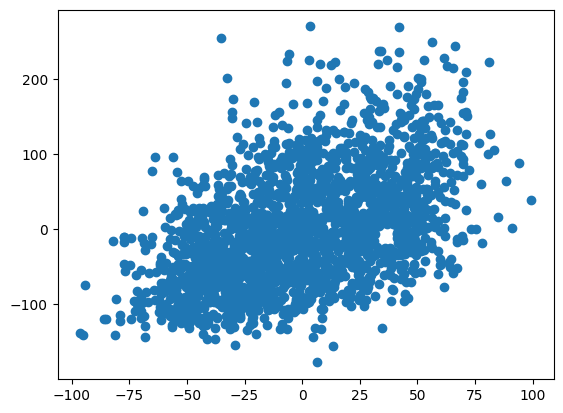

In [310]:
xt,xs,yt,ys = train_test_split(X,y)
regressor.fit(xt,yt)
plt.scatter(regressor.predict(xs),ys)

In [ ]:
# This visual is messy, but there is SOME correlation. I would conclude that there is poor support for the idea that some customers are just inherently more interested in offers than others. I would proceed with the idea that it is the offers themselves that are the variable, and I would spend more time on this.